In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
# ------------------------------------------------------------------------------
#
#   Copyright 2024 Valory AG
#
#   Licensed under the Apache License, Version 2.0 (the "License");
#   you may not use this file except in compliance with the License.
#   You may obtain a copy of the License at
#
#       http://www.apache.org/licenses/LICENSE-2.0
#
#   Unless required by applicable law or agreed to in writing, software
#   distributed under the License is distributed on an "AS IS" BASIS,
#   WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#   See the License for the specific language governing permissions and
#   limitations under the License.
#
# ------------------------------------------------------------------------------

"""Script for analyzing market creator markets."""

from collections import defaultdict
from datetime import datetime, timedelta
from enum import Enum
from mech_request_utils import get_mech_requests, IPFS_ADDRESS
from scipy import stats
from string import Template
from typing import Any, Dict

import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests

MARKET_CREATOR_ADDRESS = "0x89c5cc945dd550BcFfb72Fe42BfF002429F46Fec"

## Process mech requests
Process mech requests from the Market Creator

In [2]:
mech_requests = get_mech_requests(MARKET_CREATOR_ADDRESS)

          Fetching requests...


    Finding duplicate delivers: 100%|██████████| 1301/1301 [00:00<00:00, 1666195.27it/s]


Duplicate deliver ids found: 15


    Finding duplicate delivers: 100%|██████████| 1301/1301 [00:00<00:00, 1688363.09it/s]


Duplicate deliver ids found: 0


        Fetching IPFS contents: 100%|██████████| 1301/1301 [00:00<00:00, 1080552.38it/s]


DescribeResult(nobs=1274, minmax=(4, 42851), mean=269.96546310832025, variance=3673328.790636589, skewness=17.705724393944603, kurtosis=377.70063921734453)


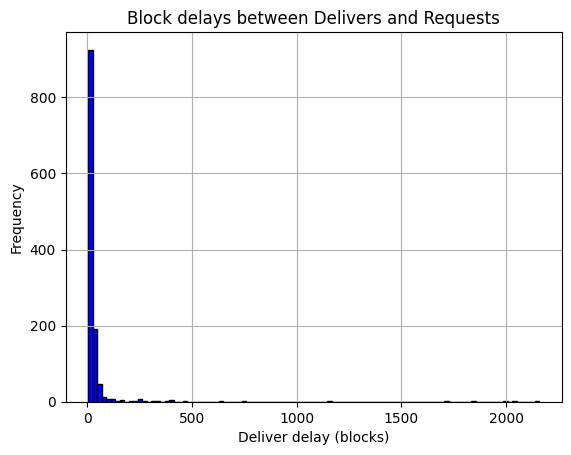

NameError: name 'json' is not defined

In [12]:
class MechDeliverState(Enum):
    """Market state"""

    INVALID_RESPONSE = 1
    RESPONSE_NOT_DETERMINABLE = 2
    RESPONSE_INVALID = 3
    RESPONSE_YES = 4
    RESPONSE_NO = 5
    UNKNOWN = 6
    NA = 7

    def __str__(self) -> str:
        """Prints the market status."""
        return self.name.lower()

# HISTOGRAM OF BLOCK DELAYS
deliver_delay_blocks = []
for request_data in mech_requests.values():
    if 'deliver' in request_data:
        request_block = int(request_data['blockNumber'])
        deliver_block = int(request_data['deliver']['blockNumber'])
        delay = deliver_block - request_block
        deliver_delay_blocks.append(delay)

deliver_delay_blocks_stats = stats.describe(deliver_delay_blocks)
print(deliver_delay_blocks_stats)

# Filter out outliers
mean = deliver_delay_blocks_stats[2]
std = np.sqrt(deliver_delay_blocks_stats[3])
alpha = 1
deliver_delay_blocks = [td for td in deliver_delay_blocks if np.abs(td - mean) <= alpha * std]

# Create histogram
plt.hist(deliver_delay_blocks, bins=100, color='blue', edgecolor='black')
plt.xlabel('Deliver delay (blocks)')
plt.ylabel('Frequency')
plt.title('Block delays between Delivers and Requests')
plt.grid(True)
plt.show()


# HISTOGRAM OF DELIVERS PER RESPONSE
result_counts = {}
for request_data in mech_requests.values():
    if 'deliver' in request_data:
        result = request_data['deliver']['ipfsContents']['result']
        result_json = json.loads(result)
        first_item_key = list(result_json.keys())[0]
        first_item_value = result_json[first_item_key]
        result = json.dumps({first_item_key: first_item_value})
        result_counts[result] = result_counts.get(result, 0) + 1
    else:
        result_counts["No Result"] = result_counts.get("No Result", 0) + 1

# Plot the counts
result_types = list(result_counts.keys())
counts = list(result_counts.values())

plt.figure(figsize=(8, 6))
plt.bar(result_types, counts, color='skyblue')
plt.xlabel('Result Type')
plt.ylabel('Count')
plt.title('Mech requests results')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()



## Process Omen markets
Process Omen markets by reading from the Omen xDAI Subgraph

In [4]:
class MarketState(Enum):
    """Market state"""

    OPEN = 1
    PENDING = 2
    FINALIZING = 3
    ARBITRATING = 4
    CLOSED = 5
    UNKNOWN = 6

    def __str__(self) -> str:
        """Prints the market status."""
        return self.name.capitalize()


answer_mapping = defaultdict(
    lambda: "Unknown",
    {
        "0x0000000000000000000000000000000000000000000000000000000000000000": "Yes",
        "0x0000000000000000000000000000000000000000000000000000000000000001": "No",
        "0xffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffff": "Invalid",
    },
)

headers = {
    "Accept": "application/json, multipart/mixed",
    "Content-Type": "application/json",
}

omen_xdai_fpmms_query = Template(
    """
    {
      fixedProductMarketMakers(
        where: {
          creator: "0x89c5cc945dd550bcffb72fe42bff002429f46fec",
          creationTimestamp_gt: "${creationTimestamp_gt}"
        }
        orderBy: creationTimestamp
        orderDirection: asc
        first: 1000
      ) {
        question {
          title
          outcomes
          currentAnswer
          currentAnswerTimestamp
          answers {
            answer
          }
        }
        id
        openingTimestamp
        resolutionTimestamp
        creationTimestamp
        isPendingArbitration
        answerFinalizedTimestamp
        currentAnswer
        collateralVolume
      }
    }
    """
)


def _get_date(timestamp: float) -> str:
    try:
        timestamp = int(timestamp)
        return datetime.utcfromtimestamp(timestamp).isoformat()
    except Exception:  # pylint: disable=broad-except
        return "--"


def _get_market_state(market: Dict[str, Any]) -> MarketState:
    try:
        now = datetime.utcnow()

        market_status = MarketState.CLOSED
        if market["currentAnswer"] is None and now >= datetime.utcfromtimestamp(float(market.get("openingTimestamp", 0))):
            market_status = MarketState.PENDING
        elif market["currentAnswer"] is None:
            market_status = MarketState.OPEN
        elif market["isPendingArbitration"]:
            market_status = MarketState.ARBITRATING
        elif now < datetime.utcfromtimestamp(float(market.get("answerFinalizedTimestamp", 0))):
            market_status = MarketState.FINALIZING

        return market_status
    except Exception:  # pylint: disable=broad-except
        return MarketState.UNKNOWN


def _get_remaining_resolution_time(market: Dict[str, Any]) -> str:
    if market["answerFinalizedTimestamp"]:
        now = datetime.utcnow()

        finalized_time = datetime.utcfromtimestamp(
            float(market["answerFinalizedTimestamp"])
        )
        time_diff = finalized_time - now

        if time_diff >= timedelta(0):
            hours = int(time_diff.total_seconds() // 3600)
            minutes = int((time_diff.total_seconds() % 3600) // 60)
            return "{:02d}:{:02d}".format(hours, minutes)
    return "--"


def _get_market_title(market: Dict[str, Any]) -> str:
    question_title = "question_title"
    url = ""
    if market.get("question"):
        question_title = market["question"].get("title", "")
        url = f'https://aiomen.eth.limo/#/{market.get("id","")}'
    return _make_clickable(question_title, url)


def _get_collateral_volume(market: Dict[str, Any]) -> str:
    volume = int(market.get("collateralVolume", 0))
    formatted_volume = f"{volume / 10**18:.2f}"
    return formatted_volume

def _get_current_answer(market: Dict[str, Any]) -> str:
    currentAnswer = market.get("currentAnswer", "")
    if not currentAnswer:
        currentAnswer = ""
    return answer_mapping.get(currentAnswer.lower(), "--")


def _get_num_answers(market: Dict[str, Any]) -> int:
    question = market.get("question", {})
    if not question:
        question = {}
    return len(question.get("answers", []))


def _execute_fpmm_query() -> Dict[str, Any]:
    url = "https://api.thegraph.com/subgraphs/name/protofire/omen-xdai"

    all_markets = []
    creationTimestamp_gt = "0"

    while True:
        query = omen_xdai_fpmms_query.substitute(
            creationTimestamp_gt=creationTimestamp_gt,
        )
        content_json = {
            "query": query,
            "variables": None,
            "extensions": {"headers": None},
        }
        res = requests.post(url, headers=headers, json=content_json, timeout=300)
        result_json = res.json()
        markets = result_json.get("data", {}).get("fixedProductMarketMakers", [])

        if not markets:
            break

        all_markets.extend(markets)
        creationTimestamp_gt = markets[len(markets) - 1]["creationTimestamp"]

    output = {"data": {"fixedProductMarketMakers": all_markets}}
    return output

def _make_clickable(text: str, url: str) -> str:
    return f'<a href="{url}" target="_blank">{text}</a>'



In [7]:
def _populate_with_mech_requests(data: Dict[str, Any], mech_requests: Dict[str, Any]) -> None:
    """Populates the markets by appending an array of the associated mech requests"""
    markets = data["data"]["fixedProductMarketMakers"]
    markets_dict = {market["question"].get("title", ""): market for market in markets if market.get("question")}

    for mech_request in mech_requests.values():
        if "ipfsContents" in mech_request:
            q = mech_request["ipfsContents"]["prompt"]
            if q in markets_dict:
                markets_dict[q].setdefault("mechRequests", []).append(mech_request)
            else:
                print("Market not found for mech request: {mech_request}")
    
    for market in markets:
        market.setdefault("mechRequests", []).sort(key=lambda x: x.get("blockNumber", 0), reverse=True)


def _get_last_mech_deliver_link(market: Dict[str, Any]) -> str:
    if market["mechRequests"]:
        request = market["mechRequests"][-1]
        if "deliver" in request:
            deliver = request["deliver"]
            ipfs_hash = deliver.get("ipfsHash", "")
            request_id = deliver.get("requestId", "")
            url = f"{IPFS_ADDRESS}{ipfs_hash}/{request_id}"
            return _make_clickable(f"[{len(market['mechRequests'])}]", url)
        return "-"
    
    return "-"

def _get_last_mech_deliver_state(market: Dict[str, Any]) -> str:
    if not market["mechRequests"]:
        return MechDeliverState.NA

    request = market["mechRequests"][-1]
    if "deliver" not in request:
        return  MechDeliverState.UNKNOWN

    result = request["deliver"]["ipfsContents"]["result"]
    
    if result == "Invalid response":
        return MechDeliverState.INVALID_RESPONSE
    elif result.replace(" ", "") == "{\"is_determinable\":false}":
        return MechDeliverState.RESPONSE_NOT_DETERMINABLE
    elif result.replace(" ", "") == "{\"has_occurred\":false}":
        return MechDeliverState.RESPONSE_NO
    elif result.replace(" ", "") == "{\"has_occurred\":true}":
        return MechDeliverState.RESPONSE_YES
    elif result.replace(" ", "").startswith("{\"is_valid\":false"):
        MechDeliverState.RESPONSE_INVALID

    return MechDeliverState.UNKNOWN





def _generate_markets_df() -> pd.DataFrame:
    data = _execute_fpmm_query()
    _populate_with_mech_requests(data, mech_requests)
    rows = []
    for entry in data["data"]["fixedProductMarketMakers"]:
        rows.append(
            {
                "Title": _get_market_title(entry),
                "Volume (xDAI):": _get_collateral_volume(entry),
                "Current answer": _get_current_answer(entry),
                "Num answers": _get_num_answers(entry),
                "State": _get_market_state(entry),
                "Remaining time to challenge (hh:mm)": _get_remaining_resolution_time(entry),
                "Creation (UTC)": _get_date(entry["creationTimestamp"]),
                "Opening (UTC)": _get_date(entry["openingTimestamp"]),
                "Answer finalized (UTC)": _get_date(entry["answerFinalizedTimestamp"]),
                "Resolution (UTC)": _get_date(entry["resolutionTimestamp"]),
                "Last mech answers": _get_last_mech_deliver_link(entry),
                "Mech answer state": _get_last_mech_deliver_state(entry)
            }
        )

    return pd.DataFrame(rows)


from IPython.display import display, HTML
df = _generate_markets_df()

# Select markets to display
market_states = [
    #MarketState.OPEN,
    MarketState.PENDING,
    #MarketState.FINALIZING,
    #MarketState.ARBITRATING,
    MarketState.CLOSED,
    #MarketState.UNKNOWN
]

df.style.set_properties(subset=["Title"], **{'text-align': 'right'})

df_filtered = df[df["State"].isin(market_states)]
pd.options.display.max_colwidth = 150
print(f"Total {[str(s) for s in market_states]} markets: {len(df_filtered)}")
html = df_filtered.to_html(escape=False, classes='sortable')

display(HTML(df_filtered.to_html(escape=False)))


Total ['Pending', 'Closed'] markets: 3118


,Title,Volume (xDAI):,Current answer,Num answers,State,Remaining time to challenge (hh:mm),Creation (UTC),Opening (UTC),Answer finalized (UTC),Resolution (UTC),Last mech answers,Mech answer state
1,Will AI progress even further in the next 4 weeks?,0.18,Invalid,1,Closed,--,2023-07-12T14:30:30,2023-07-21T00:00:00,2023-10-02T20:48:40,2024-02-20T13:45:50,-,na
2,Who will win the second test match between india and west-indies?,0.06,Yes,1,Closed,--,2023-07-13T16:11:10,2023-07-21T00:00:00,2023-12-29T14:00:05,2024-02-20T14:11:05,-,na
3,Will the James Webb Space Telescope detect an ancient galaxy that theoretically shouldn't exist by 2023-12-31?,0.05,Invalid,1,Closed,--,2023-07-14T13:19:50,2023-07-22T00:00:00,2023-09-22T10:42:20,2024-02-20T13:52:50,-,na
4,Will North America's first hydrogen-powered train be operational by 2023-09-30?,0.05,No,1,Closed,--,2023-07-14T14:48:05,2023-07-22T00:00:00,2023-09-29T17:52:10,--,-,na
5,Will AMD's Ryzen 5 5600X3D be available at other retailers besides Micro Center by 2023-08-01?,0.00,No,1,Closed,--,2023-07-14T14:49:10,2023-07-07T00:00:00,2023-09-22T10:41:50,--,-,na
6,Will the 2024 presidential election result in a more ideologically divided nation than before?,0.06,Invalid,1,Closed,--,2023-07-17T19:19:50,2023-07-10T00:00:00,2023-09-29T17:51:15,2024-02-20T14:38:10,-,na
7,Will Gannett win its lawsuit against Google for monopolizing ad tech by the end of 2023?,0.01,Invalid,1,Closed,--,2023-07-18T18:51:10,2023-07-24T00:00:00,2023-09-29T17:50:40,2024-02-20T15:13:35,-,na
8,Will the Euclid space telescope map the dark universe successfully by 2023-12-31?,0.05,Invalid,1,Closed,--,2023-07-18T19:01:45,2023-07-24T00:00:00,2023-09-29T17:50:05,2024-02-20T14:25:40,-,na
9,Will the 2024 U.S. Presidential election see a higher voter turnout than the 2020 election?,0.00,Invalid,2,Closed,--,2023-07-18T19:23:30,2023-07-14T00:00:00,2023-08-02T06:17:55,--,-,na
10,Will the missing Titanic sub be rescued by 2023-08-20?,0.00,No,1,Closed,--,2023-07-20T16:33:00,2023-07-20T00:00:00,2023-09-22T10:40:10,--,-,na
